# 3. Sentiment Analysis on Movie Polarity Dataset<br/><sub>or _feature extraction & hyper-parameter optimization_</sub>
<br/>
In this example we will try to classify movie reviews into being overall positive or negative.

The dataset we'll use is the [Sentiment Polarity Dataset](http://www.cs.cornell.edu/people/pabo/movie-review-data/) v. 2.0:
* It contains 2000 textual reviews of movies from the [Rotten Tomatoes](http://www.rottentomatoes.com/) website
* We use the _text review_ as the dataset, and the _movie rating_ (extracte from the RT page) as the truth value (review positive/negative). See the [README](http://www.cs.cornell.edu/people/pabo/movie-review-data/poldata.README.2.0.txt)
* The dataset contains 1000 positive and 1000 negative review

## Loading the data

The dataset is available as http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

It uncompresses into a folder structure that can be readily loaded by the sklearn [load_files](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html) function.

In [14]:
# Set the directory where the sentiment data will be deployed. Use a place local to your computer.
datadir = '/almacen/Media/Meta/ml/sentiment/'

import os.path
sentiment_dir = os.path.join(datadir,'txt_sentoken')

We check if the sentiment data is already there. If not, we download it and extract all the files in the designated dir

In [13]:
if not os.path.isdir(sentiment_dir):
    import urllib2
    import tarfile
    src = urllib2.urlopen( 'http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz' )
    with tarfile.open( fileobj=src, mode='r|gz' ) as sdata:
        sdata.extractall( path=datadir )
    src.close

Ok, now we _do_ have the sentiment datafiles. Let's load them into a structure ready for use with sklearn

In [15]:
from sklearn.datasets import load_files
data = load_files( sentiment_dir, shuffle=True )

Let's take a look at what the entries in the dataset look like:
* target variable is 0 (negative review) or 1 (positive review)
* datapoint is a list of text lines, containing the sentences in the review of the movie

In [17]:
idx = 2
print "Value =", data.target[idx], "\n-------\n", data.data[idx]

Value = 1 
-------
quaid stars as a man who has taken up the proffesion of dragonslayer after he feels he is betrayed by a dragon early in the movie . 
he runs into the last dragon in existence , and there is a genuinely amusing battle between the two which results in a standoff where quaid is in the dragons mouth , but has his sword pointed at the dragons brain . 
eventually , they decide to call a truce , and they work out a deal . 
since he is the last dragon , he will pretend to die and quaid will be able to get paid for it . 
their scam works at first , until they come to a town without any money . 
instead the town sacrifices a girl to the dragon , but of course , draco is a nice droagon , so he won't eat her . there is however a very amusing scene where draco is hitting on the young girl . 
of course , as you can probably tell by the plot , this is a silly movie , but it does know when to take itself seriously at the right times , unlike eddie , which was serious all the time . 

## Extracting text features

We now use [TF/IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) indexing to generate the vectors for the text data, by using the sklearn [TfIdfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) module.

With these options (intended to improve performance):
* We request a minimum document frequency of 5. This is to suppress very infrequent words, which might be good for IR (e.g. for a text search) but probably not very relevant for sentiment classification (will not define polarity in a
manner applicable across many reviews)
* We also establish a máximum document frequency of 0.8, that is, we eliminate all words that appear in more than 80% of the documents. For the same reasons than before (will not be useful to discriminate polarity, if they appear across most reviews). It is roughly equivalent to setting a stopword list, but one defined from the documents themselves.
* We activate _sublinear_tf_ normalization, that is, we replace $\mathit{tf}$ with $1 + \log(\mathit{tf})$. This makes the value of TF decrease at a slower pace, effecively making the values of high TF words (very frequent words) somehow less salient.

In [19]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the object
vect = TfidfVectorizer( min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True )

# Do the indexing and obtain the term-document matrix
X = vect.fit_transform(data.data)

Let's look at the resulting data matrix:
* 2000 lines (one per datapoint)
* ~10K columns (one per distinct word coming up after the TF/IDF indexing)

In [20]:
X.shape

(2000, 13290)

Just out of curiosity, we inspect the result of the TF/IDF indexing by looking at both ends of the scale: the words  with the highest and lowest resulting score

In [9]:
# See the 8 words with lowest IDF score
reversed_dict = { v:k for k,v in vect.vocabulary_.iteritems() }
lowest = np.argpartition(vect.idf_,8)[:8]
key = lambda x : vect.idf_[x]
for idf in sorted( lowest, key=key ):
    print "{:10} {}".format( reversed_dict[idf], vect.idf_[idf] )

movie      1.25217150997
out        1.26186463918
like       1.28951617051
was        1.29018395016
they       1.29085217605
there      1.29085217605
so         1.29823228335
you        1.30566726183


In [10]:
# See the 8 words with highest IDF score (the "rare" words)
for i in np.argpartition(vect.idf_,-8)[-8:]:
    print "{:10} {}".format( reversed_dict[i], vect.idf_[i] )

squadron   6.80964286536
priced     6.80964286536
flounder   6.80964286536
stack      6.80964286536
stacked    6.80964286536
focal      6.80964286536
flustered  6.80964286536
flown      6.80964286536


In [21]:
# How many terms were discarded in the indexing?
len( vect.stop_words_)

26369

In [22]:
# do we have sparse data (as we should in a typical TF/IDF array)?
import scipy.sparse as sp
sp.issparse(X)

True

## Training the classifier

Ok, on to train the classifier. For this example we are going to use a Random Forest classifier

In [25]:
# The usual train/test split
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

rs = check_random_state( 1352 )
Xr, Xt, yr, yt = train_test_split( X, data.target, test_size=0.30, random_state=rs )

In [72]:
# Let's try a random forest. We train with an ensemble of 30 trees
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20).fit( Xr, yr )
yp = clf.predict( Xt )

In [73]:
# How good did we get?
from sklearn.metrics import accuracy_score, confusion_matrix

print "Accuracy =", accuracy_score( yt, yp )


Accuracy = 0.725


In [74]:
# See the confusion matrix obtained
print confusion_matrix( yt, yp )

[[237  56]
 [109 198]]


## Hyper-parameter search

Now we turn to the process of selecting the best possible Random Forest for the task, to see if we can improve over the above results. For this we'll train a number of different RF configurations, and perform cross-validation for each one to find out the best. 

As a starting point, we'll look at the number of trees used.

In [29]:
from sklearn.grid_search import GridSearchCV

# The parameters we are going to try: number of trees
param_grid = [
  {'n_estimators': range(10,200,10) },
 ]

# Do a grid search over the parameter space, performing 5-fold cross-validation at each datapoint
# This will take quite a while
clfs = GridSearchCV( RandomForestClassifier(), param_grid, cv=5, n_jobs=2 )
clfs.fit(Xr, yr)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [38]:
# See what we got
print "Best parameters set found on development set:\n"
print(clfs.best_params_)

print "\nGrid scores on development set:"
for params, mean_score, scores in clfs.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:

{'n_estimators': 150}

Grid scores on development set:
0.656 (+/-0.057) for {'n_estimators': 10}
0.721 (+/-0.043) for {'n_estimators': 20}
0.732 (+/-0.031) for {'n_estimators': 30}
0.753 (+/-0.031) for {'n_estimators': 40}
0.754 (+/-0.025) for {'n_estimators': 50}
0.763 (+/-0.051) for {'n_estimators': 60}
0.774 (+/-0.030) for {'n_estimators': 70}
0.766 (+/-0.030) for {'n_estimators': 80}
0.784 (+/-0.029) for {'n_estimators': 90}
0.786 (+/-0.036) for {'n_estimators': 100}
0.790 (+/-0.049) for {'n_estimators': 110}
0.800 (+/-0.043) for {'n_estimators': 120}
0.790 (+/-0.032) for {'n_estimators': 130}
0.791 (+/-0.017) for {'n_estimators': 140}
0.802 (+/-0.045) for {'n_estimators': 150}
0.794 (+/-0.019) for {'n_estimators': 160}
0.786 (+/-0.030) for {'n_estimators': 170}
0.789 (+/-0.018) for {'n_estimators': 180}
0.793 (+/-0.033) for {'n_estimators': 190}


In [61]:
# Extract the cross-validation scores
trees = [ p.parameters['n_estimators'] for p in clfs.grid_scores_ ]
result = np.vstack( [p.cv_validation_scores for p in clfs.grid_scores_] )
result_mean = np.mean( result, axis=1 )
result_std = np.std( result, axis=1 )

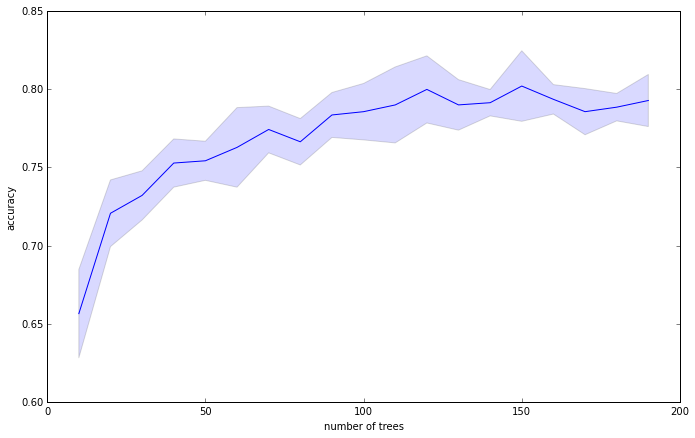

In [66]:
# And plot them
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure( 1, (7*1.62,7), dpi=200 )
from operator import itemgetter
get_means = itemgetter('mean')
plt.plot( trees, result_mean );
plt.fill_between( trees, result_mean-result_std, result_mean+result_std, alpha=0.15 );
plt.xlabel( 'number of trees');
plt.ylabel( 'accuracy' );

As we can see, the performance improvements saturate at around 80% cross-validation accuracy. Let's train a classifier with the best parameter found (150) and see its performance on the test set.

In [75]:
clf_best = RandomForestClassifier(n_estimators=150).fit( Xr, yr )
yp = clf_best.predict( Xt )

In [76]:
print "Best accuracy =", accuracy_score( yt, yp )

Best accuracy = 0.816666666667
